In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import json
import itertools
from pandas.io.json import json_normalize
import community

## INICIO DA COLETA DE DADOS

In [2]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    return categories_list[0]['name']

In [3]:
CLIENT_ID = '55LWIFZLZNZPSTAZZQKJXBD11BSBCUZTZPIXWVV4RFZJP1HS' # your Foursquare ID
CLIENT_SECRET = 'RPCOWGHQY5YNQUCHQUTC5VLKEYFGZN15FSIYTK5GNXNZ301E' # your Foursquare Secret
VERSION = '20180604'

In [4]:
latitude_nyork = 40.785091
longitude_nyork = -73.968285
radius = 10000
LIMIT = 100

In [5]:
QUERY = ''
url = 'https://api.foursquare.com/v2/venues/explore?time=any&query={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    QUERY, CLIENT_ID, CLIENT_SECRET, latitude_nyork, longitude_nyork, VERSION, radius, LIMIT)
results = requests.get(url).json()
locais = results['response']['groups'][0]['items']
locais_proximos = json_normalize(locais)
filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
locais_proximos = locais_proximos.loc[:, filtered_columns]
locais_proximos.columns = [col.split(".")[-1] for col in locais_proximos.columns]
locais_proximos['categories'] = locais_proximos.apply(get_category_type, axis=1)
locais_proximos.tail(10)

,id,name,categories,lat,lng
90,51c080d9abd88bfe62869a59,sweetgreen,Salad Place,40.744802,-73.988644
91,45940e37f964a52055401fe3,Kalustyan's,Gourmet Shop,40.742832,-73.982267
92,56e202d1498eb4f0d9ffcd68,Covina,Mediterranean Restaurant,40.742641,-73.983214
93,424de080f964a520aa201fe3,Museum of the Moving Image,Museum,40.756097,-73.924010
94,4a7b7f02f964a52037eb1fe3,Canoe Studios,Event Space,40.751750,-74.006765
95,4aeddba9f964a52096cf21e3,"Sal, Kris & Charlie's Deli",Sandwich Place,40.773304,-73.911434
96,40b68100f964a5207d001fe3,Madison Square Park,Park,40.742262,-73.988006
97,442e41b2f964a520da311fe3,Gagosian Gallery,Art Gallery,40.749493,-74.006050
98,4c5ef77bfff99c74eda954d3,Eataly,Gourmet Shop,40.741997,-73.989623
99,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205


In [6]:
checkins_locais = pd.DataFrame()
for i,local in locais_proximos.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}&limit={}'.format(
    local['id'], CLIENT_ID, CLIENT_SECRET, VERSION, 10000)
    results = requests.get(url).json()
    if (results['response']['likes']['count'] > 0) & ('items' in results['response']['likes']):
        results_2 = results['response']['likes']['items']
        checkins = json_normalize(results_2)[['id', 'firstName', 'gender']]
        checkins['avenue_id'] = local['id']
        checkins['avenue_name'] = local['name']
        checkins['avenue_categories'] = local['categories']
        checkins['avenue_lat'] = local['lat']
        checkins['avenue_lng'] = local['lng']
        if checkins_locais.empty:
            checkins_locais = checkins
        else:
            checkins_locais = pd.concat([checkins_locais, checkins], ignore_index=True)

In [7]:
#checkins_locais.to_csv('victor_likes_NY_geral.csv', index=False)

In [2]:
checkins_locais = pd.read_csv('victor_likes_NY_geral.csv')

In [6]:
checkins_locais.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
120873,155281,Eric,male,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120874,75374383,Corinne,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120875,23147845,Lindsey,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120876,15370863,Julie,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120877,76392,Sara,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205


In [32]:
locais_vc = checkins_locais['avenue_id'].value_counts()
locais_filter = locais_vc[locais_vc >= 650].index.tolist()

In [33]:
len(locais_filter)

38

In [34]:
likes_completo = checkins_locais[checkins_locais['avenue_id'].isin(locais_filter)]

In [35]:
likes_completo.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
120468,240349,Lauren ,female,4c5ef77bfff99c74eda954d3,Eataly,Gourmet Shop,40.741997,-73.989623
120469,1688817,Ayaka,female,4c5ef77bfff99c74eda954d3,Eataly,Gourmet Shop,40.741997,-73.989623
120470,5779441,Noah,male,4c5ef77bfff99c74eda954d3,Eataly,Gourmet Shop,40.741997,-73.989623
120471,32,Dens,male,4c5ef77bfff99c74eda954d3,Eataly,Gourmet Shop,40.741997,-73.989623
120472,38415,Siobhan,female,4c5ef77bfff99c74eda954d3,Eataly,Gourmet Shop,40.741997,-73.989623


In [36]:
len(likes_completo)

104413

In [37]:
vc = likes_completo['id'].value_counts()

In [42]:
filter = vc[vc >= 6].index.tolist()

In [43]:
usuarios_unicos = likes_completo[likes_completo['id'].isin(filter)]['id'].drop_duplicates()

In [44]:
usuarios_unicos = usuarios_unicos.tolist()

In [45]:
len(usuarios_unicos)

1835

In [46]:
locais_unicos = likes_completo[likes_completo['id'].isin(filter)]['avenue_id'].drop_duplicates()

In [47]:
locais_unicos = locais_unicos.tolist()

In [48]:
len(locais_unicos)

38

In [49]:
len(likes_completo[likes_completo['id'].isin(filter)])

14091

In [50]:
grafo = nx.Graph()
for usuarios in usuarios_unicos:
    grafo.add_node(str(usuarios), 
           nome=likes_completo[likes_completo['id']==usuarios]['firstName'].values[0],
           genero=likes_completo[likes_completo['id']==usuarios]['gender'].values[0])
print(nx.number_of_nodes(grafo))
for local in locais_unicos:
    # pessoas que deram like...
    pessoas = list(likes_completo[
        (likes_completo['avenue_id'] == local) & (likes_completo['id'].isin(filter))
    ]['id'].drop_duplicates().values)
    combinacoes = itertools.combinations(pessoas, 2)
    for comb in combinacoes:
        u = comb[0]
        outro = comb[1]
        if grafo.has_edge(str(u), str(outro)):
            grafo[str(u)][str(outro)]['weight'] = grafo[str(u)][str(outro)]['weight'] + 1
        else:
            grafo.add_edge(str(u), str(outro), weight=1)

1835


In [51]:
nx.write_gml(grafo, 'grafo_geral_NY_reduzido.gml')

In [3]:
grafo = nx.read_gml('grafo_geral_NY_reduzido.gml')

In [52]:
nx.number_of_nodes(grafo)

1835

In [53]:
nx.number_of_edges(grafo)

1589493

In [54]:
np.mean([grau[1] for grau in list(nx.degree(grafo, weight='weight'))])

4627.3536784741145

In [55]:
np.mean(list(nx.degree_centrality(grafo).values()))

0.9446114714787885

In [56]:
np.mean(list(nx.eigenvector_centrality(grafo, weight='weight').values()))

0.022457718535894428

In [59]:
np.mean(list(nx.betweenness_centrality(grafo, weight='weight').values()))

KeyboardInterrupt: 

In [57]:
nx.average_clustering(grafo, weight='weight')

KeyboardInterrupt: 

In [58]:
eccent = nx.eccentricity(grafo)

KeyboardInterrupt: 

In [60]:
pos = nx.spring_layout(grafo)

(-0.8159459018974485,
 1.0140388802244178,
 -1.0982204484332312,
 1.0420578503058924)

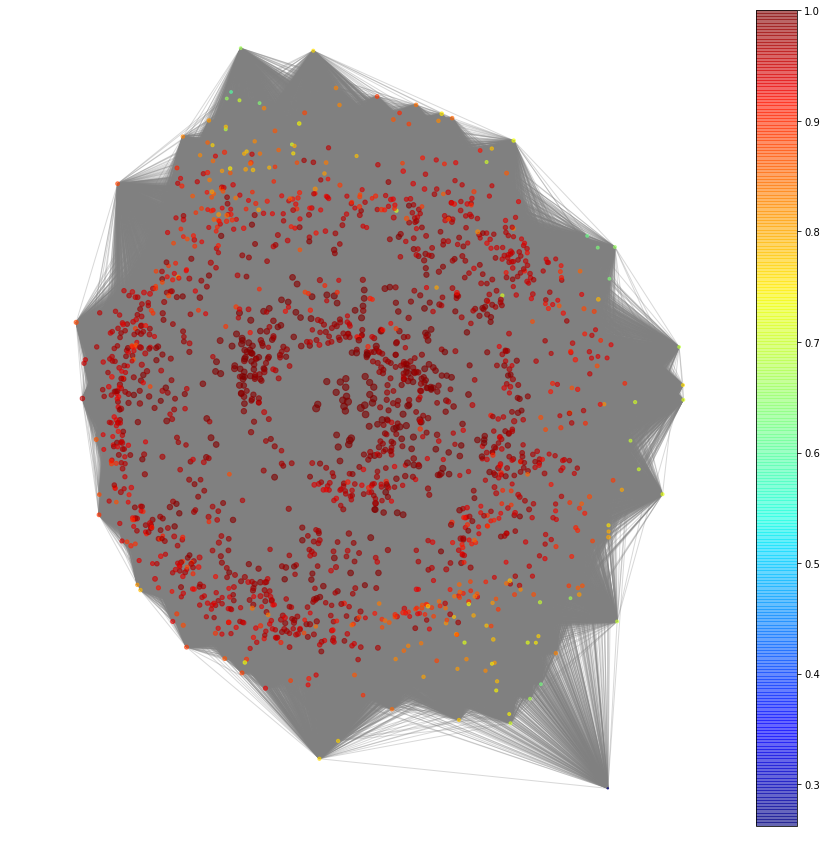

In [91]:

node_color = [cent for cent in nx.degree_centrality(grafo).values()]
node_size = [eigen * 1000 for eigen in list(nx.eigenvector_centrality(grafo, weight='weight').values())]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo, pos=pos, alpha=0.3, edge_color='gray')
no = nx.draw_networkx_nodes(grafo, pos=pos, alpha=0.6, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=min(list(nx.degree_centrality(grafo).values())), 
                            vmax=max(list(nx.degree_centrality(grafo).values())),
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')

(-0.8159459018974485,
 1.0140388802244178,
 -1.0982204484332312,
 1.0420578503058924)

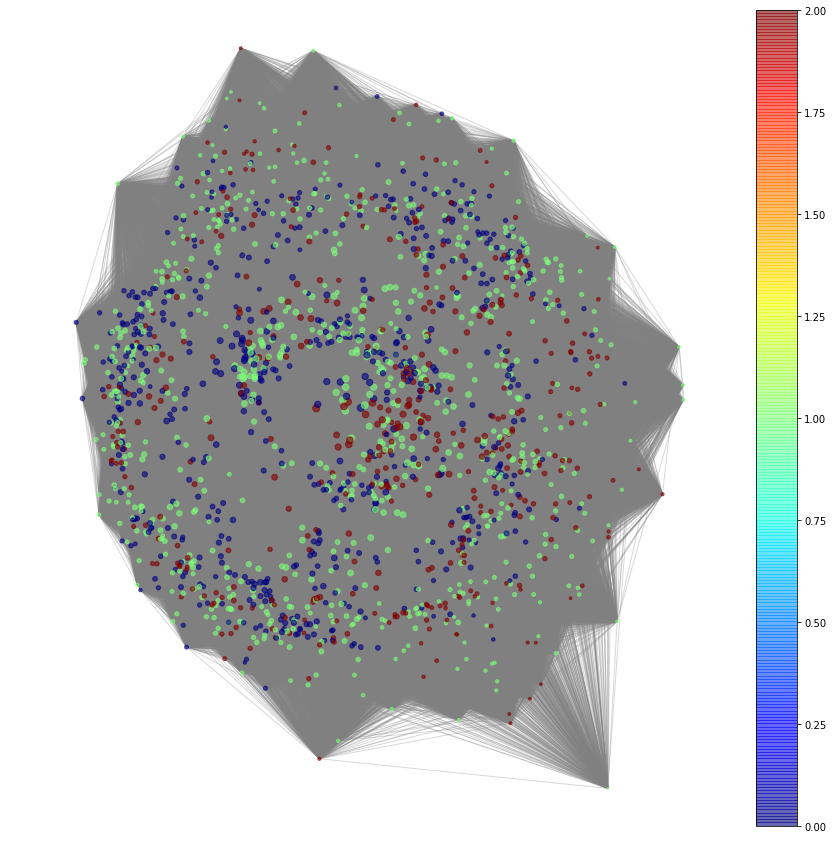

In [80]:
partition = community.best_partition(grafo, weight='weight')
node_color = [partition.get(node) for node in grafo.nodes()]
node_size = [eigen * 1000 for eigen in list(nx.eigenvector_centrality(grafo, weight='weight').values())]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo, pos=pos, alpha=0.3, edge_color='gray')
no = nx.draw_networkx_nodes(grafo, pos=pos, alpha=0.6, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=0.0, vmax=max(partition.values()),
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')

In [81]:
likes_completo['cluster'] = likes_completo['id'].apply(
    lambda x: partition[str(x)] if str(x) in list(partition.keys()) else None)

d:\git\analysis-geospatial-data\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [82]:
likes_com_cluster = likes_completo[~likes_completo['cluster'].isnull()]

In [83]:
likes_com_cluster.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng,cluster
120376,14184080,John,male,4c5ef77bfff99c74eda954d3,Eataly,Gourmet Shop,40.741997,-73.989623,2.0
120414,1033871,Eugene,male,4c5ef77bfff99c74eda954d3,Eataly,Gourmet Shop,40.741997,-73.989623,1.0
120441,7635414,Andrew,male,4c5ef77bfff99c74eda954d3,Eataly,Gourmet Shop,40.741997,-73.989623,1.0
120466,227,Lisa,female,4c5ef77bfff99c74eda954d3,Eataly,Gourmet Shop,40.741997,-73.989623,1.0
120468,240349,Lauren ,female,4c5ef77bfff99c74eda954d3,Eataly,Gourmet Shop,40.741997,-73.989623,0.0


In [84]:
len(likes_com_cluster)

14091

In [3]:
#likes_com_cluster.to_csv('victor_likes_NY_geral_cluster.csv', index=False)

In [4]:
likes_com_cluster = pd.read_csv('victor_likes_NY_geral_cluster.csv')

In [122]:
likes_com_cluster[likes_com_cluster['cluster'] == 0]['avenue_name'].value_counts()[:1]

The Metropolitan Museum of Art (Metropolitan Museum of Art)    479
Name: avenue_name, dtype: int64

In [121]:
likes_com_cluster[likes_com_cluster['cluster'] == 1]['avenue_name'].value_counts()[:1]

Bryant Park    511
Name: avenue_name, dtype: int64

In [120]:
likes_com_cluster[likes_com_cluster['cluster'] == 2]['avenue_name'].value_counts()[:1]

Rockefeller Center    360
Name: avenue_name, dtype: int64

In [116]:
influentes = []
dic = nx.degree_centrality(grafo)
for v in sorted(dic, key=dic.get, reverse=True):
    influentes.append(v)
likes_com_cluster[likes_com_cluster['id'].isin(influentes[:10])][['firstName', 'gender', 'cluster']].drop_duplicates()

,firstName,gender,cluster
308,Lizzie,female,2.0
2610,Ömer,male,2.0
3271,Camila,female,0.0
3424,Ileang,female,1.0
4424,Kate,female,1.0
5022,Christine,none,1.0
5439,Emily,female,1.0
9211,Sandra,female,1.0
12290,Davidson,male,0.0
13054,Alan,male,2.0
